# Autoencoders

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Bibliotecas básicas

In [2]:
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
tf.compat.v1.disable_eager_execution()

### Funções utilitárias

In [4]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')



def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap='Greys', interpolation='nearest')
    plt.axis('off')
    

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

### PCA com um Autoencoder linear

In [5]:
import numpy.random as rnd
from sklearn.preprocessing import StandardScaler

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)


scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
tf.compat.v1.reset_default_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden)
outputs = tf.compat.v1.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.compat.v1.global_variables_initializer()

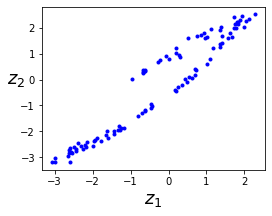

In [7]:
n_iterations = 1000
codings = hidden

with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})
    
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.show()

### Autoencoder empilhado

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [9]:
from functools import partial
from tensorflow.keras.regularizers import l2

tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0001

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
he_init = tf.compat.v1.variance_scaling_initializer()
l2_regularizer = l2(l2_reg)

my_dense_layer = partial(tf.compat.v1.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [10]:
import sys

n_epochs = 5
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X: X_batch})
      loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
      print("\r{}".format(epoch), 'Train MSE:', loss_train)
      saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_all_layers.ckpt')

0 Train MSE: 0.020049162
1 Train MSE: 0.016049055
2 Train MSE: 0.016169513
3 Train MSE: 0.016536038
4 Train MSE: 0.017584935


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_model_all_layers.ckpt


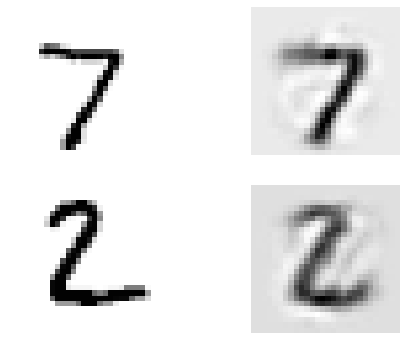

In [11]:
def show_reconstructed_digits(X, X_test, outputs, model_path = None, n_test_digits = 2):
    with tf.compat.v1.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = X_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        plt.plot()
        

show_reconstructed_digits(X, X_test, outputs, '/content/drive/MyDrive/Colab Notebooks/my_model_all_layers.ckpt')

### Amarrando os pesos

In [19]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0005

regularizer = l2(l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()
activation = tf.nn.elu

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3')  # amarrando os pesos
weights4 = tf.transpose(weights1, name='weights4')  # amarrando os pesos

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [20]:
n_epochs = 5
batch_size = 150

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X: X_batch})
      loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
      print("\r{}".format(epoch), 'Train MSE:', loss_train)
      saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt')

0 Train MSE: 0.025851537
1 Train MSE: 0.027224058
2 Train MSE: 0.027181795
3 Train MSE: 0.026340336
4 Train MSE: 0.026856996


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt


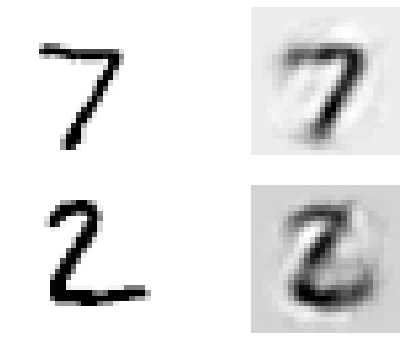

In [21]:
show_reconstructed_digits(X, X_test, outputs, '/content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt')

### Visualizando reconstruções

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt


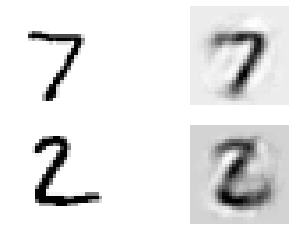

In [22]:
n_test_digits = 2
X_test = X_test[:n_test_digits]

with tf.compat.v1.Session() as sess:
    saver.restore(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt')
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Visualizando características

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt


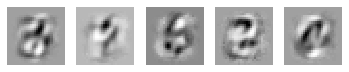

In [24]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_tying_weights.ckpt')
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
plt.show()

### Pré-treinamento não supervisionado

In [25]:
tf.compat.v1.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10
learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = l2(l2_reg)
initializer = tf.compat.v1.variance_scaling_initializer()

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.compat.v1.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name='weights3')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_outputs), name='biases3')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.compat.v1.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.compat.v1.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.compat.v1.global_variables_initializer()
pretrain_saver = tf.compat.v1.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.compat.v1.train.Saver()

#### Treinamento regular

In [35]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
      accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
      print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val)   
      saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_supervised.ckpt')

0 Train accuracy: 0.96
1 Train accuracy: 0.98
2 Train accuracy: 0.93333334
3 Train accuracy: 0.9266667


#### Treinamento reutilizando as duas primeiras camadas pré-treinadas

In [38]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

training_op = optimizer.minimize(loss, var_list=[weights3, biases3])

with tf.compat.v1.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_supervised.ckpt')
    for epoch in range(n_epochs):
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
      accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
      print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val)   
      saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_model_supervised_pretrained.ckpt')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_model_supervised.ckpt
0 Train accuracy: 0.98
1 Train accuracy: 0.9866667
2 Train accuracy: 0.98
3 Train accuracy: 0.97333336
